In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/Colab Notebooks/xview_recognition.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: xview_train/Shipping container/778dd2fe-ad63-4889-9380-8a7acba75977.tif  
  inflating: xview_train/Shipping container/7535dd1d-92f1-4007-8264-a6750c99a899.tif  
  inflating: xview_train/Shipping container/199e85aa-99c7-470b-9066-073634f2e02c.tif  
  inflating: xview_train/Shipping container/a4d2949f-f9f3-4fd3-ace0-4af8400bfd4a.tif  
  inflating: xview_train/Shipping container/44430654-4ec0-4f66-b6fa-86448807b011.tif  
  inflating: xview_train/Shipping container/ce8e443f-b915-486e-af5c-13e5f2ebb9f1.tif  
  inflating: xview_train/Shipping container/1ae7c2a0-63ee-46d4-acaa-b86d3af581b8.tif  
  inflating: xview_train/Shipping container/6efd49ec-7789-483c-93d5-90fe2d5098b0.tif  
  inflating: xview_train/Shipping container/cf285f00-3242-4259-895b-2da7282c0aaa.tif  
  inflating: xview_train/Shipping container/6d96f2ec-ed73-4639-abe7-53485b52db05.tif  
  inflating: xview_train/Shipping container/c7fc8511-d3a7-4ae9-bc6d-4

In [ ]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [ ]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 40.9 MB/s eta 0:00:00


In [ ]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [ ]:
import json
# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [ ]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.05, random_state=1, shuffle=True)


In [ ]:
# Load architecture
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model


def create_model(n_neurons):
    print('Load model')
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the convolutional base
    base_model.trainable = False

    # Create a new model on top of the pre-trained base
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = LeakyReLU(alpha=0.1)(x)  # Using Leaky ReLU activation function
    x = Dropout(0.5)(x)  # Adding dropout for regularization

    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = LeakyReLU(alpha=0.1)(x)  # Using Leaky ReLU activation function
    x = Dropout(0.5)(x)  # Adding dropout for regularization
    outputs = Dense(n_neurons, activation='softmax')(x)

    # Compile the model
    model = Model(inputs, outputs)


    # Print model summary
    model.summary()

    opt = Nadam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
import math
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 64
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

epochs = 40
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)



In [ ]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=5, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=10, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
model = create_model(12)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Load model
27018416/27018416 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb1 (Functional  (None, 7, 7, 1280)        6575239   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 142s 384ms/step - loss: 2.8149 - accuracy: 0.4554 - val_loss: 2.0927 - val_accuracy: 0.6735 - lr: 1.0000e-04
Epoch 2/40
318/318 [==============================] - ETA: 0s - loss: 2.2635 - accuracy: 0.6011
Epoch 2: val_accuracy improved from 0.67353 to 0.70159, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 111s 349ms/step - loss: 2.2635 - accuracy: 0.6011 - val_loss: 1.9160 - val_accuracy: 0.7016 - lr: 1.0000e-04
Epoch 3/40
318/318 [==============================] - ETA: 0s - loss: 2.0951 - accuracy: 0.6324
Epoch 3: val_accuracy improved from 0.70159 to 0.72311, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 108s 341ms/step - loss: 2.0951 - accuracy: 0.6324 - val_loss: 1.8217 - val_accuracy: 0.7231 - lr: 1.0000e-04
Epoch 4/40
318/318 [==============================] - ETA: 0s - loss: 1.9789 - accuracy: 0.6598
Epoch 4: val_accuracy improved from 0.72311 to 0.73620, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 104s 328ms/step - loss: 1.9789 - accuracy: 0.6598 - val_loss: 1.7501 - val_accuracy: 0.7362 - lr: 1.0000e-04
Epoch 5/40
318/318 [==============================] - ETA: 0s - loss: 1.8909 - accuracy: 0.6772
Epoch 5: val_accuracy improved from 0.73620 to 0.74181, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 97s 306ms/step - loss: 1.8909 - accuracy: 0.6772 - val_loss: 1.6901 - val_accuracy: 0.7418 - lr: 1.0000e-04
Epoch 6/40
318/318 [==============================] - ETA: 0s - loss: 1.8161 - accuracy: 0.6893
Epoch 6: val_accuracy improved from 0.74181 to 0.74462, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 100s 316ms/step - loss: 1.8161 - accuracy: 0.6893 - val_loss: 1.6371 - val_accuracy: 0.7446 - lr: 1.0000e-04
Epoch 7/40
318/318 [==============================] - ETA: 0s - loss: 1.7412 - accuracy: 0.6981
Epoch 7: val_accuracy improved from 0.74462 to 0.75304, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 102s 322ms/step - loss: 1.7412 - accuracy: 0.6981 - val_loss: 1.5831 - val_accuracy: 0.7530 - lr: 1.0000e-04
Epoch 8/40
318/318 [==============================] - ETA: 0s - loss: 1.6791 - accuracy: 0.7053
Epoch 8: val_accuracy did not improve from 0.75304
318/318 [==============================] - 104s 328ms/step - loss: 1.6791 - accuracy: 0.7053 - val_loss: 1.5332 - val_accuracy: 0.7521 - lr: 1.0000e-04
Epoch 9/40
318/318 [==============================] - ETA: 0s - loss: 1.6128 - accuracy: 0.7170
Epoch 9: val_accuracy improved from 0.75304 to 0.75491, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 107s 337ms/step - loss: 1.6128 - accuracy: 0.7170 - val_loss: 1.4943 - val_accuracy: 0.7549 - lr: 1.0000e-04
Epoch 10/40
318/318 [==============================] - ETA: 0s - loss: 1.5508 - accuracy: 0.7272
Epoch 10: val_accuracy improved from 0.75491 to 0.76146, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 105s 332ms/step - loss: 1.5508 - accuracy: 0.7272 - val_loss: 1.4468 - val_accuracy: 0.7615 - lr: 1.0000e-04
Epoch 11/40
318/318 [==============================] - ETA: 0s - loss: 1.4975 - accuracy: 0.7313
Epoch 11: val_accuracy improved from 0.76146 to 0.76520, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 107s 338ms/step - loss: 1.4975 - accuracy: 0.7313 - val_loss: 1.4109 - val_accuracy: 0.7652 - lr: 1.0000e-04
Epoch 12/40
318/318 [==============================] - ETA: 0s - loss: 1.4483 - accuracy: 0.7403
Epoch 12: val_accuracy did not improve from 0.76520
318/318 [==============================] - 107s 336ms/step - loss: 1.4483 - accuracy: 0.7403 - val_loss: 1.3693 - val_accuracy: 0.7624 - lr: 1.0000e-04
Epoch 13/40
318/318 [==============================] - ETA: 0s - loss: 1.4091 - accuracy: 0.7420
Epoch 13: val_accuracy did not improve from 0.76520
318/318 [==============================] - 109s 343ms/step - loss: 1.4091 - accuracy: 0.7420 - val_loss: 1.3462 - val_accuracy: 0.7605 - lr: 1.0000e-04
Epoch 14/40
318/318 [==============================] - ETA: 0s - loss: 1.3596 - accuracy: 0.7519
Epoch 14: val_accuracy improved from 0.76520 to 0.76614, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 110s 345ms/step - loss: 1.3596 - accuracy: 0.7519 - val_loss: 1.3089 - val_accuracy: 0.7661 - lr: 1.0000e-04
Epoch 15/40
318/318 [==============================] - ETA: 0s - loss: 1.3178 - accuracy: 0.7555
Epoch 15: val_accuracy did not improve from 0.76614
318/318 [==============================] - 107s 336ms/step - loss: 1.3178 - accuracy: 0.7555 - val_loss: 1.2754 - val_accuracy: 0.7661 - lr: 1.0000e-04
Epoch 16/40
318/318 [==============================] - ETA: 0s - loss: 1.2781 - accuracy: 0.7622
Epoch 16: val_accuracy improved from 0.76614 to 0.77549, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/318 [==============================] - 109s 342ms/step - loss: 1.2781 - accuracy: 0.7622 - val_loss: 1.2529 - val_accuracy: 0.7755 - lr: 1.0000e-04
Epoch 17/40
318/318 [==============================] - ETA: 0s - loss: 1.2430 - accuracy: 0.7638
Epoch 17: val_accuracy did not improve from 0.77549
318/318 [==============================] - 109s 344ms/step - loss: 1.2430 - accuracy: 0.7638 - val_loss: 1.2274 - val_accuracy: 0.7605 - lr: 1.0000e-04
Epoch 18/40
318/318 [==============================] - ETA: 0s - loss: 1.2106 - accuracy: 0.7713
Epoch 18: val_accuracy did not improve from 0.77549
318/318 [==============================] - 109s 343ms/step - loss: 1.2106 - accuracy: 0.7713 - val_loss: 1.1982 - val_accuracy: 0.7755 - lr: 1.0000e-04
Epoch 19/40
318/318 [==============================] - ETA: 0s - loss: 1.1757 - accuracy: 0.7710
Epoch 19: val_accuracy did not improve from 0.77549
318/318 [==============================] - 108s 339ms/step - loss: 1.1757 - accuracy: 0.7710 - va

In [ ]:
# serialize model to JSON
model_json = model.to_json()
filepath = "/content/gdrive/MyDrive/Colab Notebooks/"
with open(filepath+"model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(filepath+"model.h5")
print("Saved model to disk")

Saved model to disk


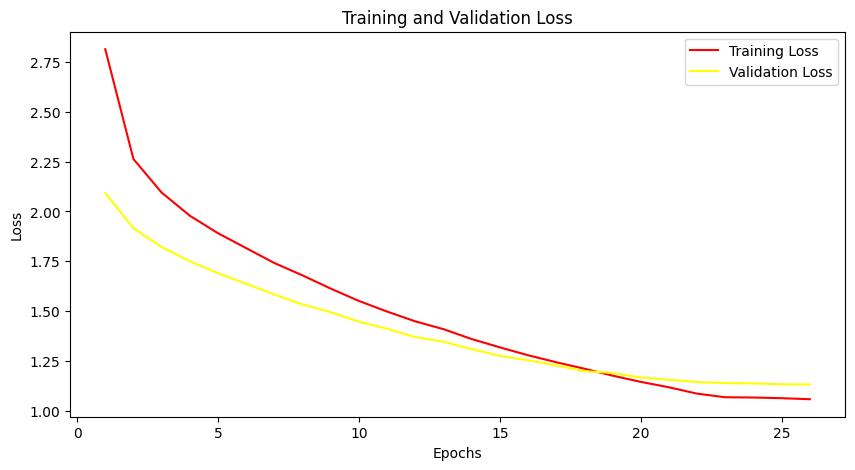

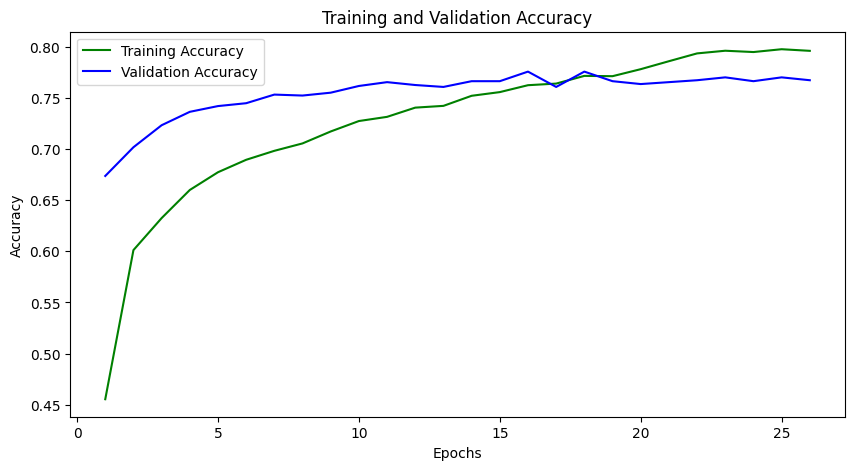

In [ ]:
# Plotting
epochs_range = range(1, 27)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['loss'], label='Training Loss', color='red')
plt.plot(epochs_range, h.history['val_loss'], label='Validation Loss', color='yellow')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['accuracy'], label='Training Accuracy', color='green')
plt.plot(epochs_range, h.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [ ]:
from keras.models import model_from_json
filepath = "/content/gdrive/MyDrive/Colab Notebooks/"
# Load JSON model architecture
json_file = open(filepath + "model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [ ]:
import numpy as np

# model.load_weights('model.keras')
y_true, y_pred = [], []
for index, ann in enumerate(anns):
    print(index)
    # Load image
    image = load_geoimage(ann.filename)
    for index, obj_pred in enumerate(ann.objects):
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)


Se han truncado las últimas 5000 líneas del flujo de salida.
1/1 [==============================] - 0s 34ms/step
136
1/1 [==============================] - 0s 34ms/step
137
1/1 [==============================] - 0s 34ms/step
138
1/1 [==============================] - 0s 36ms/step
139
1/1 [==============================] - 0s 33ms/step
140
1/1 [==============================] - 0s 33ms/step
141
1/1 [==============================] - 0s 32ms/step
142
1/1 [==============================] - 0s 30ms/step
143
1/1 [==============================] - 0s 31ms/step
144
1/1 [==============================] - 0s 33ms/step
145
1/1 [==============================] - 0s 31ms/step
146
1/1 [==============================] - 0s 30ms/step
147
1/1 [==============================] - 0s 31ms/step
148
1/1 [==============================] - 0s 32ms/step
149
1/1 [==============================] - 0s 31ms/step
150
1/1 [==============================] - 0s 30ms/step
151
1/1 [==============================] - 0s 3

<ipython-input-7-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


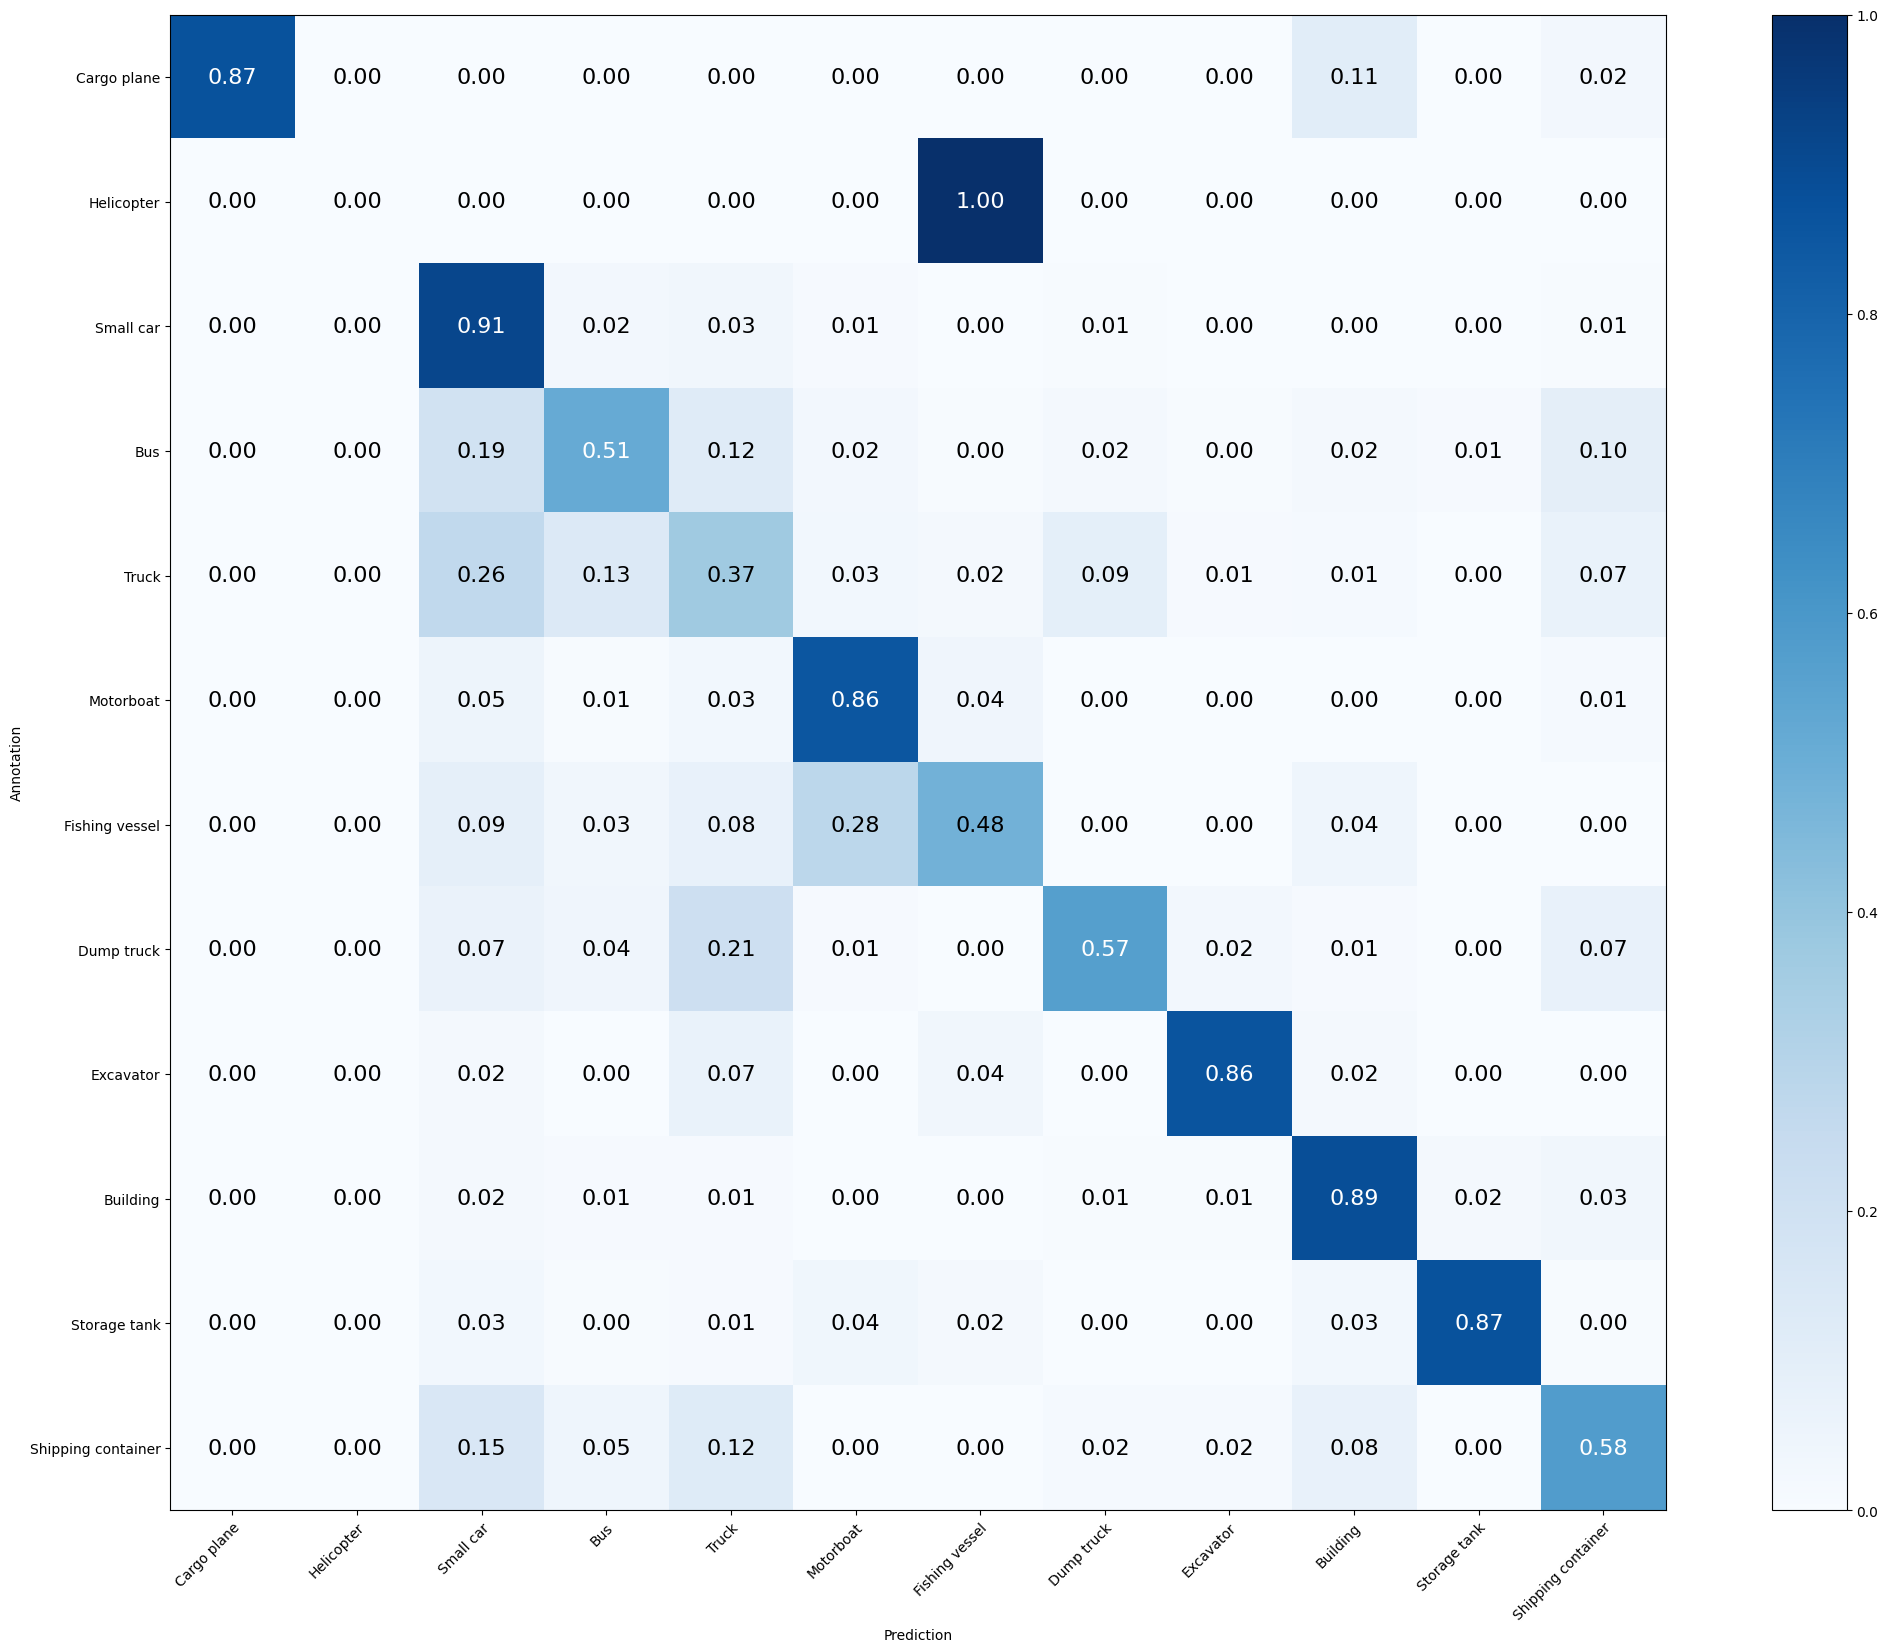

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 75.218%
Mean Recall: 64.635%
Mean Precision: 65.501%
> Cargo plane: Recall: 86.747% Precision: 97.297% Specificity: 99.922% Dice: 91.720%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 91.170% Precision: 69.811% Specificity: 91.061% Dice: 79.074%
> Bus: Recall: 51.240% Precision: 62.944% Specificity: 96.949% Dice: 56.492%
> Truck: Recall: 37.049% Precision: 50.446% Specificity: 95.236% Dice: 42.722%
> Motorboat: Recall: 85.533% Precision: 85.316% Specificity: 97.412% Dice: 85.425%
> Fishing vessel: Recall: 48.387% Precision: 57.692% Specificity: 98.702% Dice: 52.632%
> Dump truck: Recall: 56.557% Precision: 63.889% Specificity: 98.448% Dice: 60.000%
> Excavator: Recall: 85.965% Precision: 80.328% Specificity: 99.535% Dice: 83.051%
> Building: Recall: 88.561% Precision: 92.843% Specificity: 98.232% Dice: 90.652%
> Storage tank: Recall: 86.831% Precision: 93.778% Specificity: 99.415% Dice: 90.171%
> Shipping container